AIM: Generating names from languages

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open

import glob
import os
import unicodedata
import string

import random

import time
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
import torchtext as t_text


1. Get the files from the dataset
2. Turn te string to plain ASCII
3. Read a file and split it into lines
4. Build the category_lines dictionary and a list of lines per category


In [2]:
all_letters = string.ascii_letters + " .,;'-"
num_letters = len(all_letters) + 1

category_lines = {}
all_categories = []
num_categories = 0

In [3]:
def find_files(path): return glob.glob(path)

In [4]:
def unicode_to_ascii(unicode_str):
    return ''.join(c for c in unicodedata.normalize('NFD', unicode_str) if unicodedata.category(c) != 'Mn' and c in all_letters)

In [5]:
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

In [6]:
for filename in find_files('dataset/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

num_categories = len(all_categories)

if num_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data ' 
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

In [7]:
print(' Number of Categories : ', num_categories, "\n", ' List of Categories : ', all_categories)
print("+" * 89)
print( " Test  Unicode to ascii function ",unicode_to_ascii("O'Néàl"))

Number of Categories :  18 
  List of Categories :  ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
 Test  Unicode to ascii function  O'Neal


Creating the Network
This network extends the last tutorial’s RNN with an extra argument for the category tensor, which is concatenated along with the others. The category tensor is a one-hot vector just like the letter input.

We will interpret the output as the probability of the next letter. When sampling, the most likely output letter is used as the next input letter.

I added a second linear layer o2o (after combining hidden and output) to give it more muscle to work with. There’s also a dropout layer, which randomly zeros parts of its input with a given probability (here 0.1) and is usually used to fuzz inputs to prevent overfitting. Here we’re using it towards the end of the network to purposely add some chaos and increase sampling variety.

Create the Network

In [8]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        # Layers
        self.input_to_hidden = nn.Linear(num_categories + input_size + hidden_size, hidden_size)
        self.input_to_output = nn.Linear(num_categories + input_size + hidden_size, output_size)
        self.output_to_output = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.input_to_hidden(input_combined)
        output = self.input_to_output(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.output_to_output(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

1. Get random item from a list 
2. Get a random category  and random line from that category

In [9]:
def random_choice(l):
    return l[random.randint(0, len(l) - 1)]

def random_training_pair():
    # return category and line pair.
    category = random_choice(all_categories)
    return category, random_choice(category_lines[category])

For each timestep (that is, for each letter in a training word) the inputs of the network will be (category, current letter, hidden state) and the outputs will be (next letter, next hidden state). So for each training set, we’ll need the category, a set of input letters, and a set of output/target letters.

Since we are predicting the next letter from the current letter for each timestep, the letter pairs are groups of consecutive letters from the line - e.g. for "ABCD<EOS>" we would create (“A”, “B”), (“B”, “C”), (“C”, “D”), (“D”, “EOS”).


The category tensor is a one-hot tensor of size <1 x n_categories>. When training we feed it to the network at every timestep - this is a design choice, it could have been included as part of initial hidden state or some other strategy.

1. One-hot vector for category
2. One-hot matrix of first to last letters (not including EOS) for input
3. Long tensor of second letter to end (EOS) for target
4. Make category, input and target tensors from a ransom category, line pair

In [10]:
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, num_categories)
    tensor[0][li] = 1
    return tensor

def inputTensor(line):
    tensor = torch.zeros(len(line), 1, num_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(num_letters - 1)
    return torch.LongTensor(letter_indexes)

def randomTrainingExample():
    category, line = random_training_pair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [11]:
c, i,t = randomTrainingExample()
print(c.size(0), c.size())
print(i.size())
print(t.size(0), t.size())

1 torch.Size([1, 18])
torch.Size([6, 1, 59])
6 torch.Size([6])


Training the Network
In contrast to classification, where only the last output is used, we are making a prediction at every step, so we are calculating loss at every step.

The magic of autograd allows you to simply sum these losses at each step and call backward at the end.

In [12]:
loss_fxn = nn.NLLLoss()
learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):   
    target_line_tensor.unsqueeze_(-1)
    target_line_tensor = target_line_tensor.to(torch.device("cuda:0"))
    hidden = rnn.init_hidden()

    rnn.zero_grad()

    losses = 0 

    for idx in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor.to(torch.device("cuda:0")), 
        input_line_tensor[idx].to(torch.device("cuda:0")), 
        hidden.to(torch.device("cuda:0")))        

        loss = loss_fxn(output, target_line_tensor[idx])
        losses += loss
    
    losses.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    
    return output, losses.item()

To keep track of how long training takes I am adding a time_since(timestamp) function which returns a human readable string:

In [13]:
def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a few minutes, printing the current time and loss every print_every examples, and keeping store of an average loss per plot_every examples in all_losses for plotting later.

In [14]:
gpu_device = torch.device("cuda:0")
rnn = RNN(num_letters, 120, num_letters).to(gpu_device)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 

print(gpu_device)
print("+" * 89)
print(rnn)

cuda:0
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RNN(
  (input_to_hidden): Linear(in_features=197, out_features=120, bias=True)
  (input_to_output): Linear(in_features=197, out_features=59, bias=True)
  (output_to_output): Linear(in_features=179, out_features=59, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (softmax): LogSoftmax()
)


In [15]:
start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (time_since(start), iter, iter / n_iters * 100, loss))
    
    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

1m 43s (5000 5%) 15.3947
3m 19s (10000 10%) 18.5594
4m 47s (15000 15%) 13.0003
6m 21s (20000 20%) 16.8768
7m 51s (25000 25%) 25.6083
9m 14s (30000 30%) 14.2657
10m 35s (35000 35%) 16.7909
12m 11s (40000 40%) 32.8056
13m 45s (45000 45%) 14.7963
15m 17s (50000 50%) 20.8249
16m 47s (55000 55%) 11.0003
18m 21s (60000 60%) 12.5695
19m 54s (65000 65%) 7.9889
21m 26s (70000 70%) 14.3684
22m 56s (75000 75%) 8.0294
24m 26s (80000 80%) 24.1532
26m 2s (85000 85%) 4.7426
27m 33s (90000 90%) 12.9787
29m 4s (95000 95%) 14.5931
30m 35s (100000 100%) 10.7881


Plotting the Losses
Plotting the historical loss from all_losses shows the network learning:

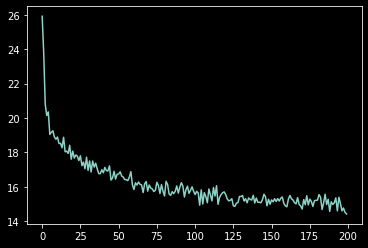

In [16]:
plt.figure()
plt.plot(all_losses)

Sampling the Network
To sample we give the network a letter and ask what the next one is, feed that in as the next letter, and repeat until the EOS token.

Create tensors for input category, starting letter, and empty hidden state
Create a string output_name with the starting letter
Up to a maximum output length,
Feed the current letter to the network
Get the next letter from highest output, and next hidden state
If the letter is EOS, stop here
If a regular letter, add to output_name and continue
Return the final name

In [24]:
max_length = 20

def sample(category, start_letter='A'):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.init_hidden()

        output_name = start_letter

        for idx in range(max_length):
            output, hidden = rnn(category_tensor.to(gpu_device), 
            input[0].to(gpu_device), hidden.to(gpu_device))
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == num_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)
        
        return output_name

In [25]:
# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [29]:
samples('Russian', 'RUS')
print("-" * 89)
samples('German', 'GER')
print("-" * 89)
samples('Spanish', 'SPA')
print("-" * 89)
samples('Chinese', 'CHI')
print("-" * 89)
samples("English", 'WBO')

Rovakov
Uantovov
Santovovev
-----------------------------------------------------------------------------------------
Gertan
Ering
Roun
-----------------------------------------------------------------------------------------
Sandera
Pare
Allan
-----------------------------------------------------------------------------------------
Cha
Han
Iuan
-----------------------------------------------------------------------------------------
Wanton
Bander
Ollan
